<a href="https://colab.research.google.com/github/HXong/MadeGames/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing dependencies and define helper functions

In [53]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [20]:
env = gym.make("CartPole-v1")

Action Space: The cart can move left (0) or right (1).

In [21]:
print("Action Space:", env.action_space)

Action Space: Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [22]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


###Importing torch for agent

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

###Define the Q-Network (Neural Network for DQN) using Pytorch

self.fc1 => extracts from input state (with 64 neurons)

self.fc2 => Further processes the information

self.fc3 => Outputs Q-values for actions  

###output = (state * weights) + bias

---------------------------------------------------------

torch.relu introduces non-linearity, helping the network learn better.

--> Basically, for any negative values, it will become 0 (if not it will act as a simple linear function)

fc3 does not require reLU as Q-values can be negative or positive.

In [24]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

###Experience Replay Buffer

Purpose is to store past experiences so the agent can learn from them (RL learning)

Methods:

-->add(): Adds a new experience (state, action, reward, next_state, done).

-->sample(): Retrieves a random batch of experiences for training.

-->size(): Returns the number of stored experiences.

In [25]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

###Initialize DQN Training Components

q_network --> Main DQN model (used for selecting actions).

target_network --> Separate copy of the network (stabilizes training).

Optimizer --> Adam is used for gradient descent updates.

Loss Function --> MSELoss (Mean Squared Error) is used to measure Q-value errors.

In [39]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check for graphics card

# Hyperparameters
learning_rate = 0.001 #higher value means learns faster but unstable
gamma = 0.99 # using the formula from lecture, Q(s,a)=r+(gamma)maxQ(s', a') => 0.99 value future rewards more highly
batch_size = 32
epsilon = 1.0 #initial exploration rate (fully random before epsilion)
epsilon_decay = 0.995 #gradual exploration before shifting to exploration (from q values)
epsilon_min = 0.01
buffer_size = 10000
target_update = 10 #how often the target network is updated
num_episodes = 750

q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
replay_buffer = ReplayBuffer(buffer_size)

###Define action choosing

With probability epsilon, choose a random action (exploration).
Otherwise, choose the action with the highest Q-value (exploitation).

In [40]:
def choose_action(state, epsilon):
    if random.random() < epsilon:
        return random.choice([0, 1])  # exploration
    else:
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return torch.argmax(q_values).item()  # Best action (exploitation)

## Task 1: Development of an RL agent

###Training of agent

Loops through multiple training episodes (1000 episodes to learn from the states).

Agent learns from past experiences and updates the Q-network.

Target network is updated every 10 episodes.

In [41]:
reward_history = []
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = choose_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if replay_buffer.size() >= batch_size:
            batch = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(np.stack(states)).to(device)
            actions = torch.LongTensor(np.array(actions)).to(device)
            rewards = torch.FloatTensor(np.array(rewards)).to(device)
            next_states = torch.FloatTensor(np.stack(next_states)).to(device)
            dones = torch.FloatTensor(np.array(dones)).to(device)

            q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_network(next_states).max(1)[0]
            target_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = loss_fn(q_values, target_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if episode % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())

    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

torch.save(q_network.state_dict(), "cartpole_dqn.pth")

Episode 0, Total Reward: 26.0
Episode 1, Total Reward: 15.0
Episode 2, Total Reward: 41.0
Episode 3, Total Reward: 20.0
Episode 4, Total Reward: 38.0
Episode 5, Total Reward: 27.0
Episode 6, Total Reward: 21.0
Episode 7, Total Reward: 28.0
Episode 8, Total Reward: 44.0
Episode 9, Total Reward: 21.0
Episode 10, Total Reward: 31.0
Episode 11, Total Reward: 15.0
Episode 12, Total Reward: 38.0
Episode 13, Total Reward: 30.0
Episode 14, Total Reward: 13.0
Episode 15, Total Reward: 9.0
Episode 16, Total Reward: 40.0
Episode 17, Total Reward: 12.0
Episode 18, Total Reward: 13.0
Episode 19, Total Reward: 14.0
Episode 20, Total Reward: 17.0
Episode 21, Total Reward: 22.0
Episode 22, Total Reward: 11.0
Episode 23, Total Reward: 14.0
Episode 24, Total Reward: 11.0
Episode 25, Total Reward: 15.0
Episode 26, Total Reward: 14.0
Episode 27, Total Reward: 23.0
Episode 28, Total Reward: 37.0
Episode 29, Total Reward: 12.0
Episode 30, Total Reward: 46.0
Episode 31, Total Reward: 12.0
Episode 32, Total R

For Task 1, we can show the observation and chosen action below:

In [42]:
state = env.reset()
action = choose_action(state, 0.0)

print("state: ", state)
print("Choosen action: ", action)

state:  [-0.03312256 -0.03317246 -0.0180353  -0.00396399]
Choosen action:  1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

<ipython-input-48-329acaf63f3f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_network.load_state_dict(torch.load("cartpole_dqn.pth"))


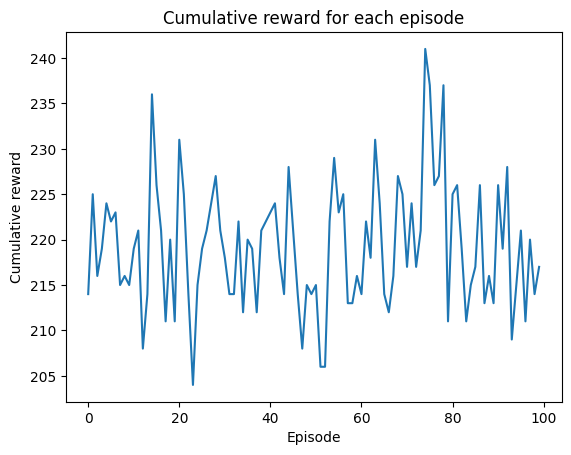

In [48]:
q_network = QNetwork(state_size, action_size).to(device)
q_network.load_state_dict(torch.load("cartpole_dqn.pth"))
q_network.eval()

eval_episode_results = []
num_eval_episodes = 100

for episode in range(num_eval_episodes):
  state = env.reset()
  total_reward = 0
  done = False

  while not done:
    action = choose_action(state, 0.0)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = next_state

  eval_episode_results.append(total_reward)


plt.plot(eval_episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()


Print the average reward over the 100 episodes.

In [49]:
average_reward = np.mean(eval_episode_results)
print("Average cumulative reward:", average_reward)
print("Is my agent good enough?", average_reward > 195)

Average cumulative reward: 219.2
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [50]:
from gym.wrappers import RecordVideo

In [54]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = choose_action(observation, 0.0)
    observation, reward, done, _ = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
